In [16]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [17]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_sx1.fits'],
      dtype='<U67')

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24010_x1d.fits
G140L
[513.2145]


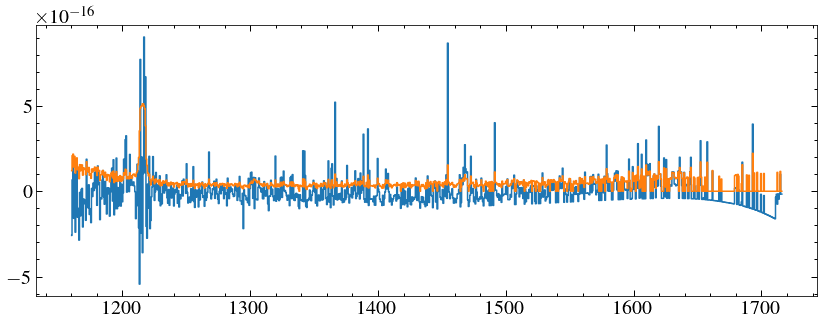

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24020_x1d.fits
G140L
[512.62335]


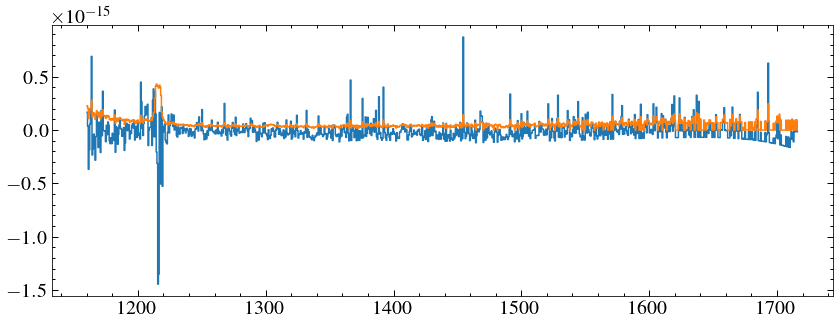

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24030_x1d.fits
G140L
[512.64307]


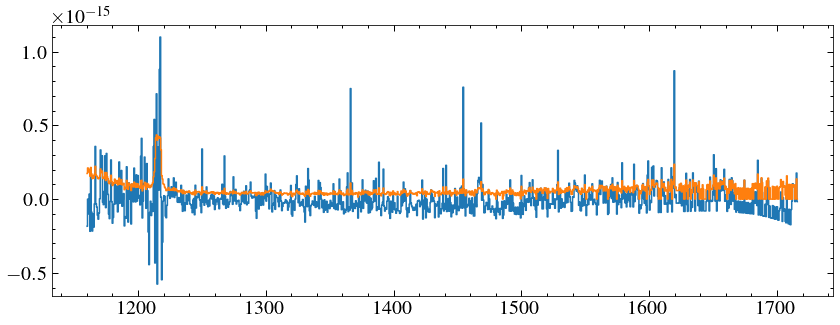

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_x1d.fits
G230L
[492.99686]


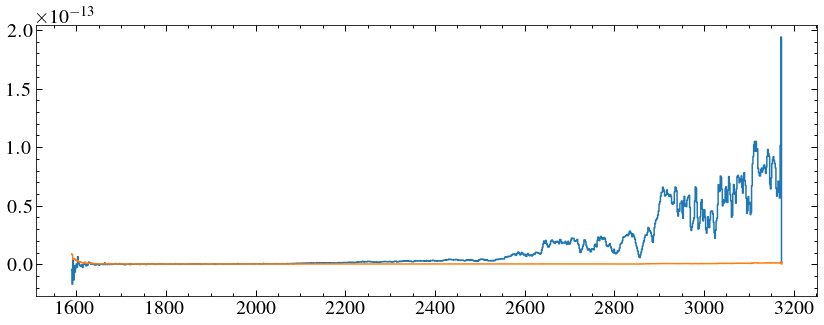

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_x1d.fits
G140M
[872.3185]


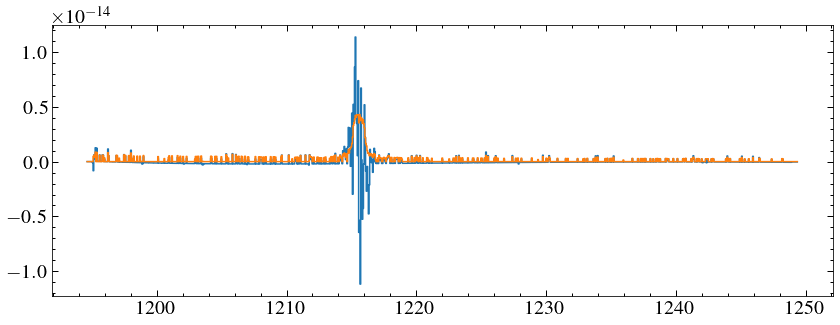

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_sx1.fits
G430L
[894.11395]


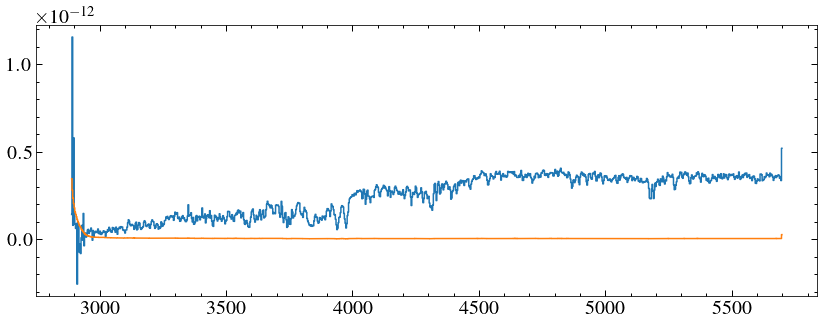

In [18]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

    

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_x1d.fits
G230L
[492.99686]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_x1d.fits
G140M
[872.3185]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_sx1.fits
G430L
[894.11395]


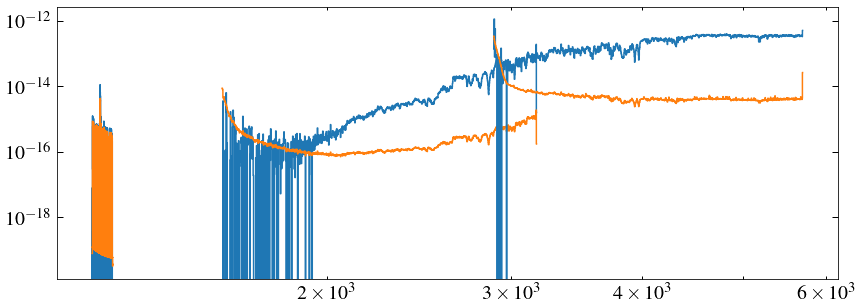

In [19]:
for x in x1ds[3:]:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')


plt.yscale('log')
plt.xscale('log')

plt.show()





In [20]:
flts = glob.glob('{}*flt.fits'.format(path))
flts

['/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24020_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24030_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24010_flt.fits']

oeoo24020


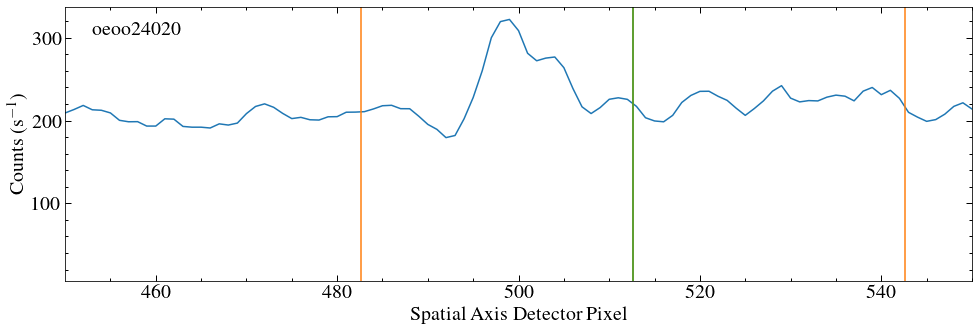

oeoo24030


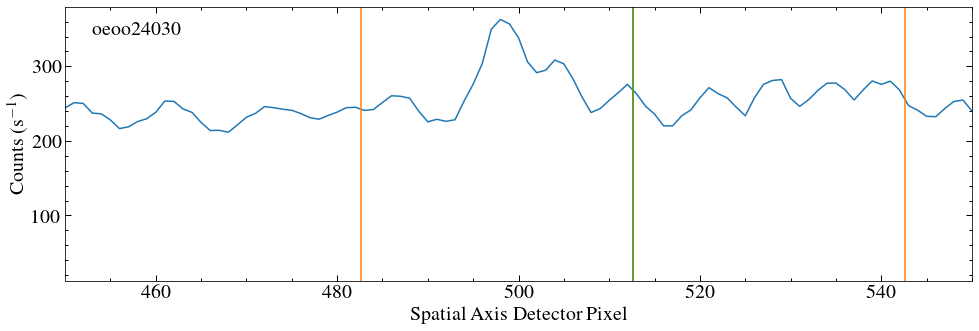

oeoo24010


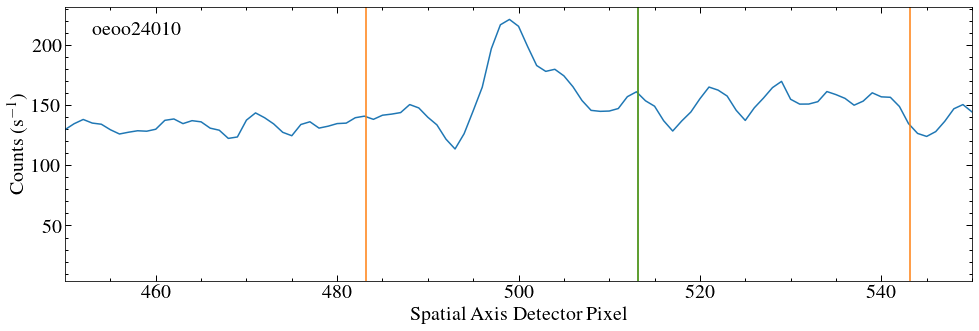

In [21]:
checkrow = 200
for flt in flts:
    hdr = fits.getheader(flt, 0)
    grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
    if grating == 'G140L':       
        print(root)
        data = fits.getdata(flt, 1)
        data = np.transpose(data) #flip the image to make the next row more simple
        data = data[350:800]
        data = np.sum(data, axis=0)
        data = convolve(data,  Box1DKernel(4))
        plt.plot(np.arange(len(data)), data)
        
        spec = fits.getdata('{}{}_x1d.fits'.format(path, root))[0]
        [plt.axvline(line, c='C1') for line in (spec['A2CENTER'], spec['A2CENTER']+spec['BK1OFFST'], spec['A2CENTER']+spec['BK2OFFST'])]
        plt.axvline(spec['A2CENTER'], c='C2')      
        plt.ylabel('Counts (s$^{-1}$)')
        plt.xlabel('Spatial Axis Detector Pixel')
        plt.annotate('{}'.format(root), (0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
        plt.xlim(450, 550)
        plt.tight_layout()
        plt.show()

Need to re-extract the G140L (+ maybe G140M) spectra. S/N is really low, might need to coadd flats before extracting.

In [22]:
import stistools
os.environ['oref'] = path

In [23]:
# for root in  ['oeoo24010', 'oeoo24020', 'oeoo24030']:

#     raw = '{}/{}_flt.fits'.format(path, root)
#     rootname = fits.getheader(raw)['ROOTNAME'] 
#     outname = 'reextractions/{}_new_x1d.fits'.format(rootname)
#     stistools.x1d.x1d(raw, output = outname, trailer='reextractions/{}_new.trl'.format(rootname), a2center=495, maxsrch=10)

499.70148


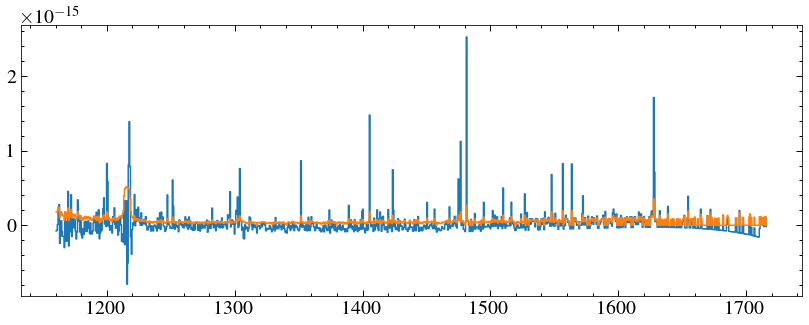

499.15488


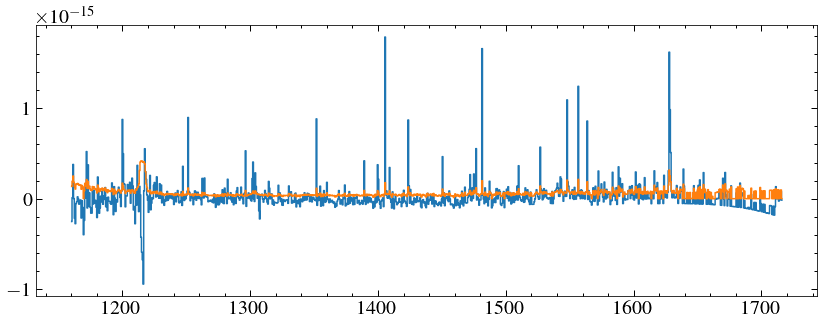

499.12582


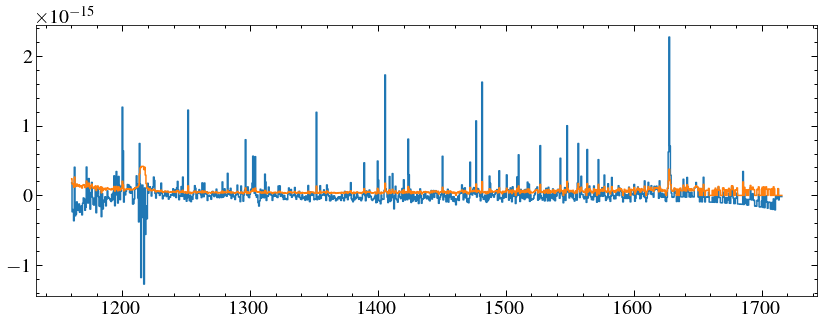

In [24]:
for root in  ['oeoo24010', 'oeoo24020', 'oeoo24030']:
        data = fits.getdata('reextractions/{}_new_x1d.fits'.format(root), 1)[0]
        print(data['A2Center'])
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = w > 1160
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid')
        plt.step(w, e, where='mid')
        plt.show()

Tried with a2center = 495, 500, looks like that's as good as it's going to get

In [25]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [26]:
new_x1ds = glob.glob('reextractions/*240*x1d*')
new_x1ds

['reextractions/oeoo24030_new_x1d.fits',
 'reextractions/oeoo24020_new_x1d.fits',
 'reextractions/oeoo24010_new_x1d.fits']

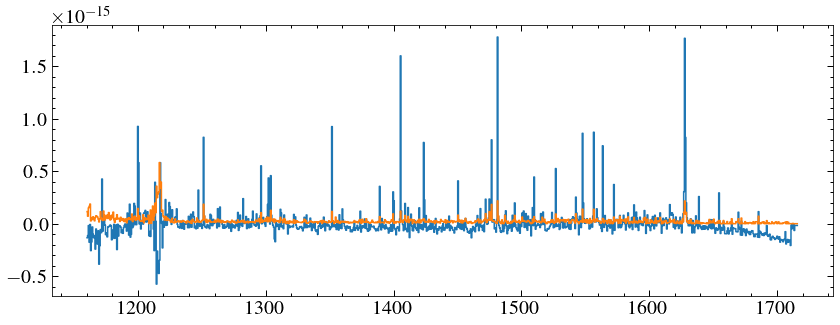

In [27]:
w_fuv = []
f_fuv = []
e_fuv = []

n=0
for x in new_x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        n +=1

f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)

plt.step(w_fuv, f_fuv, where='mid')
plt.step(w_fuv, e_fuv, where='mid')

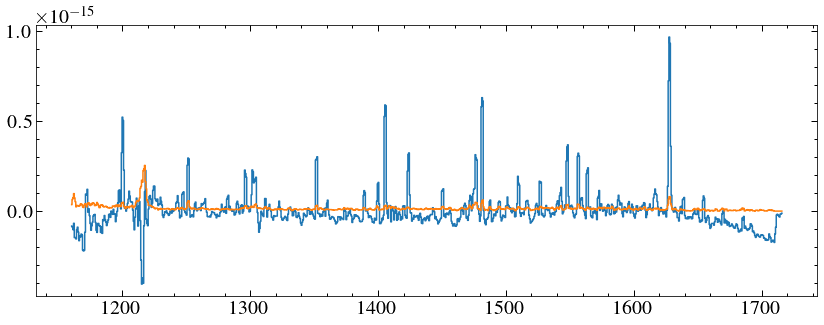

In [28]:
fi = convolve(f_fuv,  Box1DKernel(3))
ei = convolve(e_fuv,  Box1DKernel(3))/3**0.5
plt.step(w_fuv, fi, where='mid')
plt.step(w_fuv, ei, where='mid')


In [29]:
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1700) & (w <3130)
        w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]

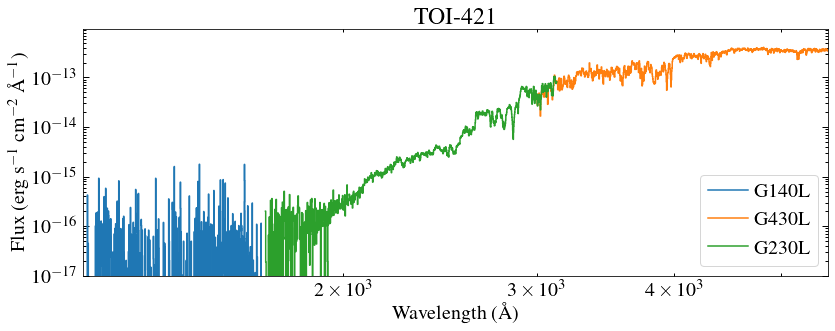

In [34]:
plt.figure(figsize=(12, 5))

plt.step(w_fuv, f_fuv, where='mid', label ='G140L')
plt.step(w_opt, f_opt, where='mid', label='G430L')
plt.step(w_nuv, f_nuv, where='mid', label='G230L')


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-17)
plt.xlim(1160, 5520)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('TOI-421')
plt.tight_layout()
plt.savefig('plots/toi-421_ql.pdf')
plt.savefig('plots/toi-421_ql.png', facecolor='w')